Demonstrates performance of scMODAL on the citeSeq PBMC dataset

In [1]:
!git clone https://github.com/gefeiwang/scMODAL.git

fatal: destination path 'scMODAL' already exists and is not an empty directory.


In [2]:
!cp -r scMODAL/scmodal scmodal

In [3]:
!pip install anndata scanpy numba umap-learn torch annoy gdown

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8024 sha256=2b1e8eb62cda7bad28bb76ece87da01d4fc60fc16c36d99b023f473eee04ba7c
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn

Instructions to generate this preprocessed data are in scMODAL_PBMC

In [55]:
!gdown -q 1ja8aXvTFcASyvNRDCosmXyXQaRG9XvmU
!gdown -q 1rTe5KFGJfLBsZy2UjYD5Cl1SVlX8jcSb
!gdown -q 1tfD4sz_fIA71WuZtytlo98JrY8QPhrjV

In [32]:
import anndata
import scanpy as sc
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

In [34]:
rna_adata = sc.read_h5ad("protein_adata.h5ad")
protein_adata = sc.read_h5ad("protein_adata.h5ad")

In [35]:
correspondence = pd.read_csv('protein_gene_conversion.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [39]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [43]:
# Determine the indices of shared columns
shared_rna_indices = rna_protein_correspondence[:, 0]
shared_protein_indices = rna_protein_correspondence[:, 1]

RNA_adata = rna_adata[:, ~rna_adata.var_names.duplicated()]
Protein_adata = protein_adata[:, ~protein_adata.var_names.duplicated()]

# Identify the non-shared columns
all_rna_columns = np.array(RNA_adata.var_names)
all_protein_columns = np.array(Protein_adata.var_names)

non_shared_rna_indices = np.setdiff1d(all_rna_columns, shared_rna_indices)
non_shared_protein_indices = np.setdiff1d(all_protein_columns, shared_protein_indices)

# Reorder the columns so that shared columns come first
reordered_rna_adata = RNA_adata[:, np.concatenate([shared_rna_indices, non_shared_rna_indices])]
reordered_protein_adata = Protein_adata[:, np.concatenate([shared_protein_indices, non_shared_protein_indices])]

# Save the reordered AnnData objects as bmc_rna and bmc_protein
RNA_adata = reordered_rna_adata
Protein_adata = reordered_protein_adata

n_shared = len(shared_rna_indices)

In [44]:
# row sum for RNA
rna_counts = rna_adata.X.sum(axis=1)
# row sum for protein
protein_counts = protein_adata.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

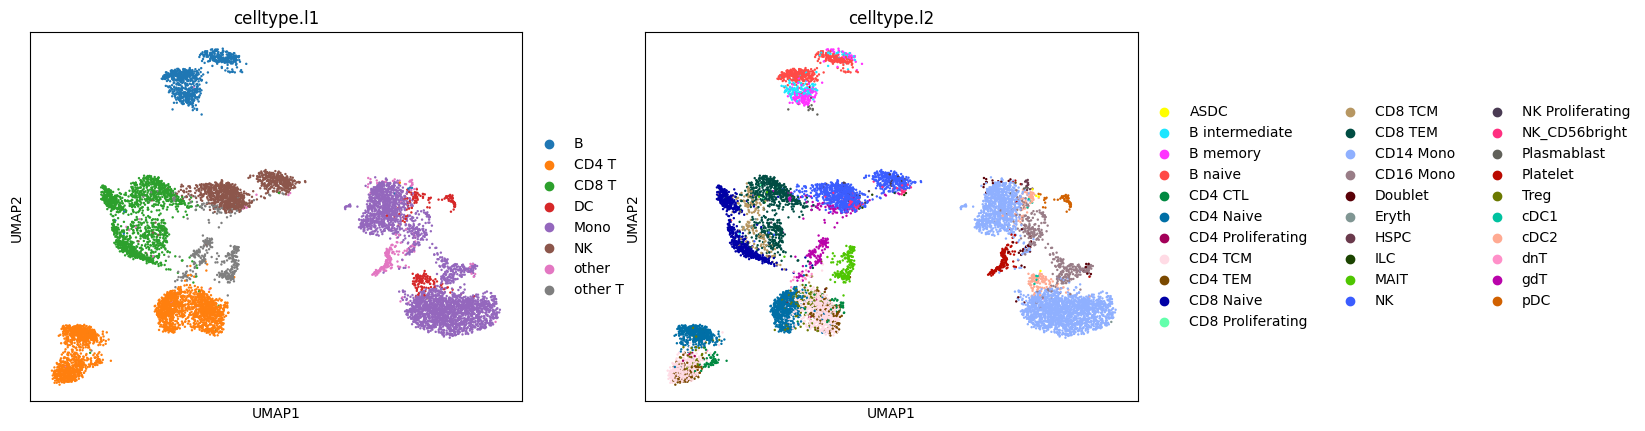

In [45]:
# process rna_shared
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.scale(rna_adata)
# plot UMAPs of rna cells based only on rna markers with protein correspondence
sc.pp.neighbors(rna_adata, n_neighbors=15)
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata, color=['celltype.l1','celltype.l2'])

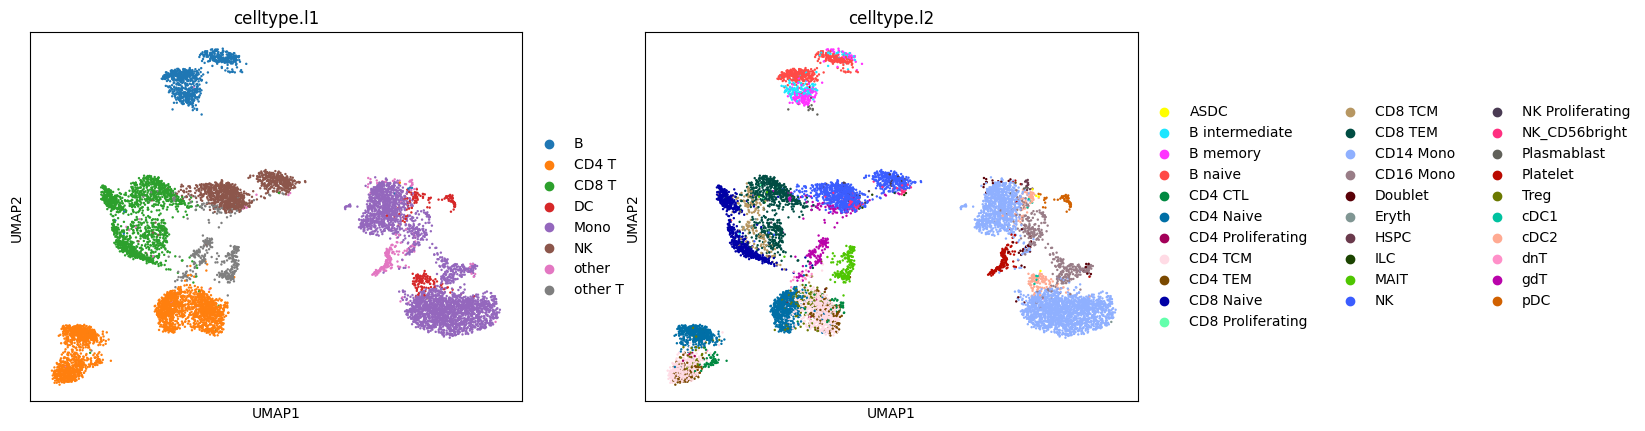

In [46]:
# process protein_shared
sc.pp.normalize_total(protein_adata)
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)
# plot UMAPs of protein cells based only on protein markers with rna correspondence

sc.pp.neighbors(protein_adata, n_neighbors=15)
sc.tl.umap(protein_adata)
sc.pl.umap(protein_adata, color=['celltype.l1','celltype.l2'])

## Model Training

In [47]:
import scmodal

model = scmodal.model.Model()
model.preprocess(rna_adata, protein_adata, shared_gene_num=180)
model.train() # train the model
model.eval() # get integrated latent representation of cells

Begining time:  Tue Nov 26 22:56:58 2024
step 0, loss_D=0.094264, loss_GAN=-0.060264, loss_AE=88.443893, loss_Geo=-12.803792, loss_LA=636.883789, loss_MNN=12.102133
step 2000, loss_D=1.338202, loss_GAN=-1.331120, loss_AE=9.062990, loss_Geo=-19.497242, loss_LA=0.034419, loss_MNN=0.232214
step 4000, loss_D=1.312576, loss_GAN=-1.307880, loss_AE=9.049614, loss_Geo=-19.491638, loss_LA=0.235298, loss_MNN=0.177081
step 6000, loss_D=1.352095, loss_GAN=-1.348437, loss_AE=8.559067, loss_Geo=-19.497290, loss_LA=0.056205, loss_MNN=0.211280
step 8000, loss_D=1.384988, loss_GAN=-1.384494, loss_AE=8.387317, loss_Geo=-19.496639, loss_LA=0.015974, loss_MNN=0.229206
Ending time:  Tue Nov 26 23:11:45 2024
Training takes 886.52 seconds
Begining time:  Tue Nov 26 23:11:45 2024
Ending time:  Tue Nov 26 23:11:45 2024
Evaluating takes 0.03 seconds


## Model Evaluation

In [48]:
adata_int = anndata.AnnData(X=model.latent)
adata_int.obs = pd.concat([rna_adata.obs, protein_adata.obs])
adata_int.obs['modality'] = ['RNA'] * rna_adata.shape[0] + ['ADT'] * protein_adata.shape[0]

scmodal.utils.compute_umap(adata_int)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_jobs=1, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Tue Nov 26 23:11:45 2024 Construct fuzzy simplicial set
Tue Nov 26 23:11:45 2024 Finding Nearest Neighbors
Tue Nov 26 23:11:45 2024 Building RP forest with 12 trees
Tue Nov 26 23:11:45 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Nov 26 23:11:49 2024 Finished Nearest Neighbor Search
Tue Nov 26 23:11:49 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 26 23:12:05 2024 Finished embedding


... storing 'modality' as categorical


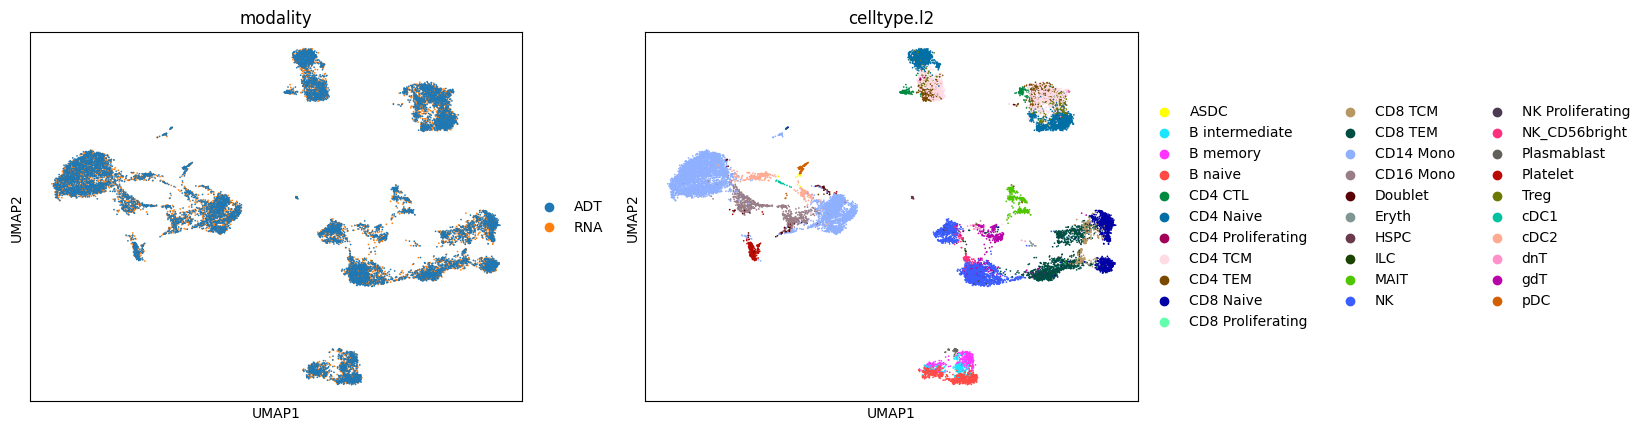

In [49]:
sc.pl.umap(adata_int,color=['modality','celltype.l2'])

In [50]:
from scipy.spatial.distance import cdist

dist_mtx = cdist(model.latent[rna_adata.shape[0]:, :],
                 model.latent[:rna_adata.shape[0], :],
                 metric='euclidean') # Transfer labels from RNA to ADT

matching = dist_mtx.argsort()[:, :1]

df1_labels = rna_adata.obs["celltype.l1"].values
df2_labels = protein_adata.obs["celltype.l1"].values

print("Label transfer accuracy: ", np.sum(df1_labels == df2_labels[matching.reshape(-1)]) / rna_adata.shape[0])

Label transfer accuracy:  0.9978


In [51]:
df1_labels_2 = rna_adata.obs["celltype.l2"].values
df2_labels_2 = protein_adata.obs["celltype.l2"].values

print("Label transfer accuracy: ", np.sum(df1_labels_2 == df2_labels_2[matching.reshape(-1)]) / rna_adata.shape[0])

Label transfer accuracy:  0.9796


### FOSCTTM

In [52]:
rna_cca, protein_cca = model.latent[rna_adata.shape[0]:, :], model.latent[:rna_adata.shape[0], :]

In [53]:
def cdist_correlation(arr1, arr2):
    """Calculate pair-wise 1 - Pearson correlation between X and Y.

    Parameters
    ----------
    arr1: np.array of shape (n_samples1, n_features)
        First dataset.
    arr2: np.array of shape (n_samples2, n_features)
        Second dataset.

    Returns
    -------
    array-like of shape (n_samples1, n_samples2)
        The (i, j)-th entry is 1 - Pearson correlation between i-th row of arr1 and j-th row of arr2.
    """
    n, p = arr1.shape
    m, p2 = arr2.shape
    assert p2 == p

    arr1 = (arr1.T - np.mean(arr1, axis=1)).T
    arr2 = (arr2.T - np.mean(arr2, axis=1)).T

    arr1 = (arr1.T / np.sqrt(1e-6 + np.sum(arr1 ** 2, axis=1))).T
    arr2 = (arr2.T / np.sqrt(1e-6 + np.sum(arr2 ** 2, axis=1))).T

    return 1 - arr1 @ arr2.T

def get_foscttm(dist, true_matching='identity'):
    """
    Compute the fraction of samples closer than true match.

    Parameters
    ----------
    dist: np.ndarray of shape (n1, n2)
        Distance matrix.
    true_matching: 'identity' or Iterable of length n1, default='identity'
        If is a list, then the ground truth matched pairs are (i, true_matching[i])
        If is 'identity', then true_matching = [0, 1..., n1].

    Returns
    -------
    The fraction of samples closer than true match.
    """
    n1, _ = dist.shape
    if true_matching == 'identity':
        true_matching = np.arange(n1)
    elif isinstance(true_matching, Iterable):
        true_matching = [i for i in true_matching]
    else:
        raise NotImplementedError('true_matching must be \'identity\' or Iterable of length dist.shape[0].')
    # mask[i, j] = True iff dist[i, j] < dist[i, true_matching[i]]
    mask = (dist.T < dist[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))

dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

get_foscttm(
    dist=cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.0009216100000000001